In [17]:
import logging
from enum import Enum
from pathlib import Path
from typing import List, Tuple

import joblib
import numpy as np
import pandas as pd
from rdkit import Chem
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

from rxitect.models.vanilla.predictor import Predictor
from rxitect.log_utils import print_auto_logged_info


class AlgorithmType(Enum):
    RF = "RF"


def random_forest_cv(X, y, X_ind, y_ind, reg: bool = False, n_splits: int = 5):
    """Cross validation and Independent test for RF classification/regression model.
    Arguments:
        X (np.ndarray): m x n feature matrix for cross validation, where m is the number of samples
            and n is the number of features.
        y (np.ndarray): m-dimensional label array for cross validation, where m is the number of samples and
            equals to row of X.
        X_ind (np.ndarray): m x n Feature matrix for independent set, where m is the number of samples
            and n is the number of features.
        y_ind (np.ndarray): m-d label array for independent set, where m is the number of samples and
            equals to row of X_ind, and l is the number of types.
        reg (bool): it True, the training is for regression, otherwise for classification.
        n_splits (int): number of splits to use for cross validation


     Returns:
        cvs (np.ndarray): m x l result matrix for cross validation, where m is the number of samples and
            equals to row of X, and l is the number of types and equals to row of X.
        inds (np.ndarray): m x l result matrix for independent test, where m is the number of samples and
            equals to row of X, and l is the number of types and equals to row of X.
    """
    if reg:
        folds = KFold(n_splits=n_splits).split(X)
        alg = RandomForestRegressor
    else:
        folds = StratifiedKFold(n_splits=n_splits).split(X, y)
        alg = RandomForestClassifier

    cvs = np.zeros(y.shape)
    inds = np.zeros(y_ind.shape)
    for trained, validated in tqdm(iterable=folds, desc="RF CV Outer Loop"):
        model = alg(n_estimators=1_000, n_jobs=-1, verbose=1)
        model.fit(
            X[trained],
            y[trained],
            sample_weight=[1 if v >= 4 else 0.1 for v in y[trained]],
        )
        if reg:
            cvs[validated] = model.predict(X[validated])
            inds += model.predict(X_ind)
        else:
            cvs[validated] = model.predict_proba(X[validated])[:, 1]
            inds += model.predict_proba(X_ind)[:, 1]

    return cvs, inds / n_splits


def cross_validation(
    X,
    y,
    X_ind,
    y_ind,
    alg: AlgorithmType = AlgorithmType.RF,
    reg: bool = False,
) -> Tuple[np.ndarray, np.ndarray]:
    if alg == AlgorithmType.RF:
        cv, ind = random_forest_cv(X, y[:, 0], X_ind, y_ind[:, 0], reg=reg)
    else:
        raise ValueError(
            f"Algorithm Type {alg} does not exist. Please pick from the following: {list(AlgorithmType)}"
        )
    return cv, ind


def train_rf(X, y, out_filepath: Path, reg: bool = False) -> None:
    if reg:
        model = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
    else:
        model = RandomForestClassifier(n_estimators=1000, n_jobs=-1)

    joblib.dump(value=model, filename=out_filepath, compress=3)


def single_task(
    feat: str = None,
    alg: AlgorithmType = AlgorithmType.RF,
    ligand_path: Path = None,
    pair: List[str] = None,
    reg: bool = False,
    is_extra: bool = True,
    px_threshold: float = 6.5,
) -> None:
    df = pd.read_table(ligand_path).dropna(subset=pair[1:2])
    df = df[df[pair[0]] == feat]
    df = df[pair].set_index(pair[1])
    year = df[pair[-1:]].groupby(pair[1]).min().dropna()
    test = year[year[pair[-1]] > 2015].index
    numery = df[pair[2]].groupby(pair[1]).mean().dropna()

    comments = df[(df.Comment.str.contains("Not Active") == True)]
    inhibits = df[
        (df.Standard_Type == "Inhibition") & df.Standard_Relation.isin(["<", "<="])
    ]
    relations = df[
        df.Standard_Type.isin(["EC50", "IC50", "Kd", "Ki"])
        & df.Standard_Relation.isin([">", ">="])
    ]
    binary = pd.concat([comments, inhibits, relations], axis=0)
    binary = binary[~binary.index.isin(numery.index)]
    binary[pair[2]] = 3.99
    binary = binary[pair[2]].groupby(binary.index).first()
    df = numery.append(binary) if is_extra else numery
    if not reg:
        df = (df > px_threshold).astype(float)
    df = df.sample(len(df))
    logging.info(
        f"""
        Feat: {feat}
        Above px={px_threshold}: {len(numery[numery >= px_threshold])}
        Below px={px_threshold}: {len(numery[numery < px_threshold])}
        Binaries: {len(binary)}
    """
    )

    test_ix = set(df.index).intersection(test)
    test = df.loc[test_ix].dropna()
    data = df.drop(test.index)

    test_x = Predictor.calc_fp([Chem.MolFromSmiles(mol) for mol in test.index])
    data_x = Predictor.calc_fp([Chem.MolFromSmiles(mol) for mol in data.index])
    out_dir = Path("../models/")

    # if not Path.exists(out_dir):
    #     logging.info(
    #         f"Creating directories to store environment training output @ '{out_dir}'"
    #     )
    #     Path(out_dir).mkdir(parents=True)

    out = out_dir / f"{alg.value}_{'REG' if reg else 'CLF'}_{feat}"
    X = np.concatenate([data_x, test_x], axis=0)
    y = np.concatenate([data.values, test.values], axis=0)
    train_rf(X, y, out_filepath=(out.with_suffix(".pkg")), reg=reg)
    data, test = data.to_frame(name="Label"), test.to_frame(name="Label")
    data["Score"], test["Score"] = cross_validation(
        data_x, data.values, test_x, test.values, alg, reg=reg
    )
    data.to_csv(out.with_suffix(".cv.tsv"), sep="\t")
    test.to_csv(out.with_suffix(".ind.tsv"), sep="\t")


def main():
    import os

    pair = [
        "Target_ChEMBL_ID",
        "Smiles",
        "pChEMBL_Value",
        "Comment",
        "Standard_Type",
        "Standard_Relation",
        "Document_Year",
    ]

    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    # targets = ["CHEMBL226", "CHEMBL251", "CHEMBL240"]
    targets = ['CHEMBL240']

    for target in targets:
        single_task(
            feat=target,
            ligand_path=Path("../data/raw/ligand_raw.tsv"),
            pair=pair,
            reg=True,
        )


if __name__ == "__main__":
    main()


/tmp/ipykernel_121870/3043287999.py:123: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = numery.append(binary) if is_extra else numery
/tmp/ipykernel_121870/3043287999.py:137: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  test = df.loc[test_ix].dropna()
RF CV Outer Loop: 0it [00:00, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.5min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[

In [18]:
import matplotlib.pyplot as plt

def fig(target, out=None):
    plt.figure(figsize=(4, 4))
    cat = ['cv', 'ind']
    for j, legend in enumerate(['Cross Validation', 'Independent Test']):
        df = pd.read_table(f"../models/RF_REG_{target}.{cat[j]}.tsv")
        df = df[df.Label != 3.99]
        plt.scatter(df.Label, df.Score, s=5, label=legend)
    plt.xlim([3.5, 10.5])
    plt.ylim([3.5, 10.5])
    plt.xlabel('Real pX')
    plt.ylabel('Predicted pX')
    plt.legend(loc='upper left')
    if out is None:
        plt.show()
    else:
        plt.savefig(out, dpi=300)

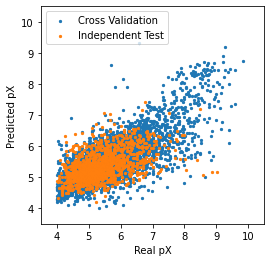

In [19]:
fig('CHEMBL240')

In [20]:
from sklearn.metrics import r2_score, mean_squared_error

In [25]:
df = pd.read_table("../models/RF_REG_CHEMBL240.cv.tsv")
df = df[df.Label != 3.99]

In [35]:
r2_score(y_true=df.Label, y_pred=df.Score, multioutput='raw_values', sample_weight=[1 if v>=4 else 0.1 for v in df.Label])

array([0.57682988])

In [30]:
mse = mean_squared_error(y_true=df.Label, y_pred=df.Score)

In [31]:
np.sqrt(mse)

0.5941057597874742